# kaggle competition on diabetic classification

## 1. Import Libraries
Load required dependencies for data processing and modeling.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from lightgbm import LGBMClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Load Data
Read training data and preview the structure.

In [19]:
train= 'train.csv'
test= 'test.csv'

df= pd.read_csv(train)

df.head(10)

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0
5,5,42,1,100,4.4,6.4,5.3,25.5,0.84,111,67,77,174,42,101,95,Female,White,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
6,6,41,2,148,3.4,5.6,3.7,27.9,0.89,130,77,73,168,41,106,137,Female,White,Graduate,Lower-Middle,Current,Employed,0,0,0,1.0
7,7,51,3,102,4.0,7.3,5.5,27.1,0.83,125,82,66,182,45,105,132,Male,Asian,Highschool,Low,Never,Employed,1,0,0,1.0
8,8,34,2,44,2.7,7.0,7.9,22.6,0.81,120,79,65,163,68,69,97,Male,White,Highschool,Lower-Middle,Never,Employed,0,0,0,0.0
9,9,44,1,36,5.8,5.7,6.6,29.3,0.88,110,65,66,171,48,97,153,Male,Hispanic,Highschool,Middle,Never,Employed,1,0,0,1.0


## 3. Feature Engineering
Encode categorical variables using one-hot and ordinal encoding.

In [20]:
encoder= OrdinalEncoder()
ohe= OneHotEncoder(sparse_output=False, drop='first')

categorical_cols= [
    'ethnicity',
    'gender',
    'education_level',
    'income_level',
    'smoking_status',
    'employment_status'
]

encoded_array = ohe.fit_transform(df[categorical_cols])
encoded_cols= ohe.get_feature_names_out(categorical_cols)

encoded_df= pd.DataFrame(encoded_array, columns=encoded_cols,index=df.index)
df= pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

df.head(10)



,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes,ethnicity_Black,ethnicity_Hispanic,ethnicity_Other,ethnicity_White,gender_Male,gender_Other,education_level_Highschool,education_level_No formal,education_level_Postgraduate,income_level_Low,income_level_Lower-Middle,income_level_Middle,income_level_Upper-Middle,smoking_status_Former,smoking_status_Never,employment_status_Retired,employment_status_Student,employment_status_Unemployed
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,62,199,58,114,102,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,71,199,50,121,124,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,73,188,59,114,108,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,74,182,54,85,123,0,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,85,206,49,131,124,0,1,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
5,5,42,1,100,4.4,6.4,5.3,25.5,0.84,111,67,77,174,42,101,95,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6,6,41,2,148,3.4,5.6,3.7,27.9,0.89,130,77,73,168,41,106,137,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,51,3,102,4.0,7.3,5.5,27.1,0.83,125,82,66,182,45,105,132,1,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,8,34,2,44,2.7,7.0,7.9,22.6,0.81,120,79,65,163,68,69,97,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,9,44,1,36,5.8,5.7,6.6,29.3,0.88,110,65,66,171,48,97,153,1,0,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# 4. Correlation analysis on encoded features

see correlation between features to remove any redundant features

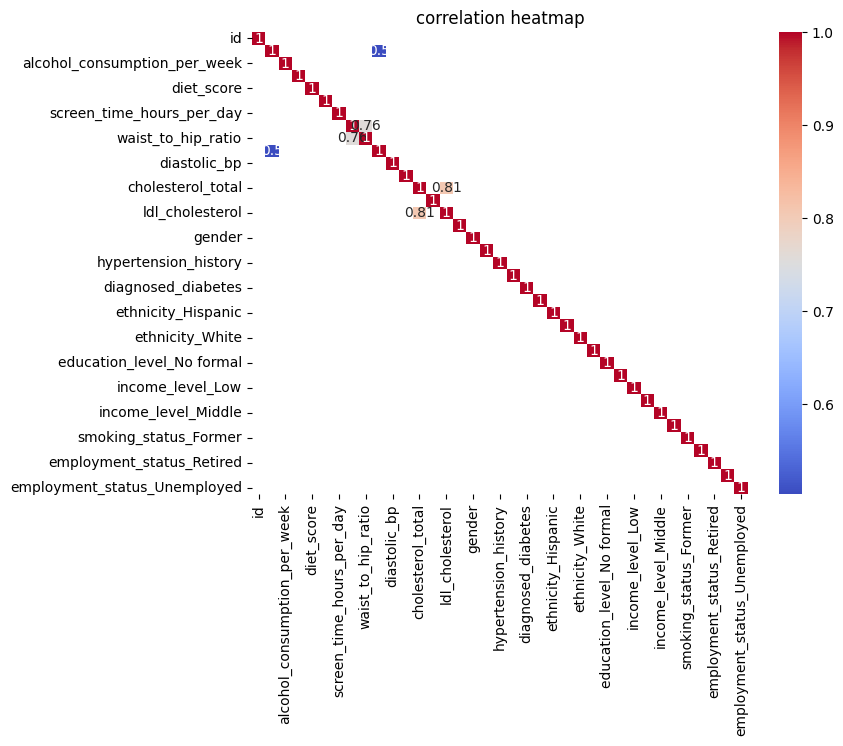

Highly correlated features: [('waist_to_hip_ratio', 'bmi'), ('ldl_cholesterol', 'cholesterol_total')]


In [19]:
corr_matrix= df.corr()
threshold = 0.5
strong_corr = corr_matrix[(corr_matrix >= threshold)]

plt.figure(figsize=(8,6))
sns.heatmap(strong_corr, annot=True, cmap='coolwarm')
plt.title("correlation heatmap")
plt.show()

high_corr=[]

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j]>0.7):
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print("Highly correlated features:", high_corr)


# Feature Interactions and dropping redundant columns

remove correlated columns as shown by heatmap and introduce feature interactions

In [21]:
#df.drop(columns=['waist_to_hip_ratio','ldl_cholesterol'],inplace=True)

df['bmi_age']= df['bmi']*df['age']
#df['physical_activity_sleep']=df['physical_activity_minutes_per_week']*(df['sleep_hours_per_day']*7)
df['family_history_Squared']= df['family_history_diabetes']**2
df['triglycerides_sq']= df['triglycerides']**2





## 4. Model Training & Tuning
Train LGBMClassifier with hyperparameter optimization via RandomizedSearchCV.

In [22]:
x= df.drop(columns=['id','diagnosed_diabetes'])
y= df['diagnosed_diabetes']

X_train, X_test, y_train, y_test= train_test_split(x,y, test_size=0.2, random_state=42)

def train_model(model,param_grid,X_train,y_train,X_test,y_test):

    cv= StratifiedKFold( n_splits=5, shuffle=True, random_state=42)

    grid = RandomizedSearchCV(model, param_grid,n_iter=10, cv=cv,n_jobs=-1, scoring='roc_auc')
    grid.fit(X_train,y_train)

    print("best cv score", grid.best_score_)
    print("best params:", grid.best_params_)

    best_score= grid.best_estimator_

    test_score_pred = best_score.predict_proba(X_test)[:,1]
    test_auc= roc_auc_score(y_test, test_score_pred)
    print('test auc score', test_auc)

    return best_score,test_score_pred,test_auc

model1= LGBMClassifier()
model2= xgb.XGBClassifier(eval_metric='auc')
model3= CatBoostClassifier(verbose=0)

xgb_params = {
    'n_estimators': [ 500,600],
    'max_depth': [6,7,8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [ 0.8],
    'colsample_bytree': [0.8]
}

lgb_params = {
    'n_estimators': [500],
    'max_depth': [5,6],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

cat_params = {
    'iterations': [600, 800],
    'depth': [ 6, 8],
    'learning_rate': [0.03, 0.05, 0.1],
    'bagging_temperature': [0, 1, 2]
}

best_lgb, lgb_pred, lgb_auc = train_model(model1, lgb_params, X_train, y_train, X_test, y_test)
#best_xgb, xgb_pred, xgb_auc = train_model(model2, xgb_params, X_train, y_train, X_test, y_test)
#best_cat, cat_pred, cat_auc = train_model(model3, cat_params, X_train, y_train, X_test, y_test)


/home/aayam/Diabetes_kaggle/venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 279148, number of negative: 168852
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 279149, number of negative: 168851
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 279149, number of negative: 168851
[LightGBM] [Info] Number of positive: 279149, number of negative: 168851
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 279149, number of negative: 168851
[LightGBM] [Info] Number of positive: 279149, number of negative: 168851
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[L

## 5. Generate Submission
Prepare test data and create submission file with predictions.

In [23]:
test_df= pd.read_csv(test)
X_test_final = test_df.drop(columns=['id'])

cat_cols = X_test_final.select_dtypes(include='object').columns

# Fill missing with 'missing' if any
X_test_final[cat_cols] = X_test_final[cat_cols].fillna('missing')

# One-hot encode
X_test_final = pd.get_dummies(X_test_final, columns=cat_cols)

missing_cols = set(X_train.columns) - set(X_test_final.columns)
for c in missing_cols:
    X_test_final[c] = 0

X_test_final = X_test_final[X_train.columns]

lgb_final_pred = best_lgb.predict_proba(X_test_final)[:,1]


submission = pd.DataFrame({
    'id': test_df['id'],
    'diagnosed_diabetes': lgb_final_pred
})

submission.to_csv('submission.csv', index=False)


